Plant Disease Classification Project: 
first we are importing all the necessary libraies and loading the dataset

In [91]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers


Loading the DataSet

In [92]:
image_size = 256
batch_size = 32
channels = 3 
data_set = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=True,
)

class_names = data_set.class_names
print(class_names)
num_of_classes = len(class_names)
print(type(num_of_classes))

Found 2152 files belonging to 3 classes.
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
<class 'int'>


12


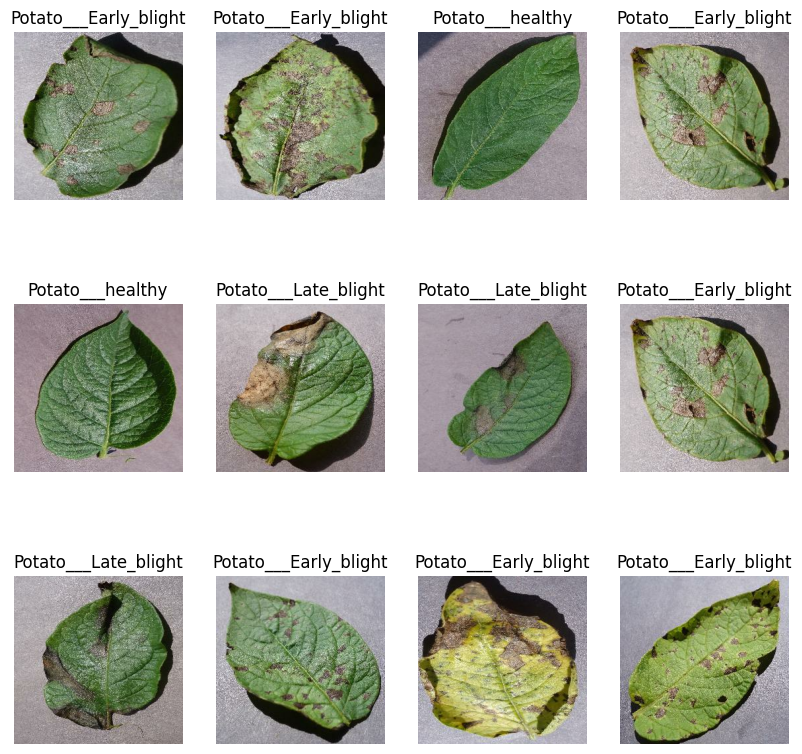

In [93]:
count = 0
plt.figure(figsize=(10,10))

for i in range(12):
    for img ,leb in data_set.take(1):
        plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(label= class_names[leb[i].numpy()])
        plt.axis("off")
        #print(img[0].numpy())
        count+=1
print(count)


In [94]:
for img,leb in data_set.take(1):
    print(class_names[leb[0].numpy()])

Potato___Early_blight


Now we are splitting the dataset in 3 parts train, validation, test dataset in a percentage of 80,10,10

In [95]:
def get_dataset_split(ds=data_set,training_fraction = 0.8 ,validation_fraction = 0.1,test_fraction=0.1,shuffle=True,shuffle_size=1000):
    print("getting started")
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    traing_dataset = ds.take(int(training_fraction*len(ds)))
    validation_dataset = ds.skip(int(training_fraction*len(ds))).take(int(validation_fraction*len(ds)))
    test_dataset = ds.skip(int(training_fraction*len(ds))).skip(int(validation_fraction*len(ds)))

    return traing_dataset,validation_dataset,test_dataset

In [96]:
int(len(data_set)*0.8)

54

In [97]:
train_dataset,val_dataset,test_dataset = get_dataset_split(data_set)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

getting started
54
6
8


Now we will be doing cacheing and prefetching for better performence

In [98]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

Resize and Rescaling

In [99]:
resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1.0/255),
    layers.Resizing(image_size,image_size)
])

Adding Random Flip and Random Rotation (Data Augumentation)

In [100]:
random_flip_and_rotate = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

Making our own Custom Model

In [107]:
input_shape = (batch_size,image_size,image_size,channels)
model = tf.keras.Sequential([
    resize_and_rescale,
    random_flip_and_rotate,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),#64 is number of nurons in the first layer
    layers.Dense(num_of_classes,activation="softmax")#output layer with 3 nurons

])

model.build(input_shape)


In [108]:
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_19 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_20 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits =False),
    metrics=['accuracy']
)